In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'C:/Users/felip/OneDrive/Documentos/Escola/2018/IA/T4/train'
#endereço da pasta de testes
TEST_DIR = 'C:/Users/felip/OneDrive/Documentos/Escola/2018/IA/T4/test'
#mesmo tamanho de imagem
IMG_SIZE = 50
#define learning rate
LR = 1e-3

In [2]:
#classificação das imagens
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'bat' : return [1,0]
    elif word_label == 'sup' : return [0,1]

In [3]:
#preparação para treinamento
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        #normalização das imagens
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    return training_data

In [4]:
#preparação para testes
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    return testing_data

In [5]:
train_data = create_train_data()

100%|██████████| 129/129 [00:00<00:00, 1795.72it/s]


In [12]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf

tf.reset_default_graph()
#1 camada
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
#conv2d para imagens 2D
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [13]:
train = train_data[:-1]
test = train_data[0:]

In [14]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [15]:
model.fit({'input': X}, {'targets': Y}, n_epoch=50, validation_set=({'input': test_x}, {'targets': test_y}), show_metric=True)

Training Step: 99  | total loss: 0.52541 | time: 0.187s
| Adam | epoch: 050 | loss: 0.52541 - acc: 0.8528 -- iter: 064/128
Training Step: 100  | total loss: 0.63430 | time: 1.374s
| Adam | epoch: 050 | loss: 0.63430 - acc: 0.8175 | val_loss: 0.41552 - val_acc: 0.7984 -- iter: 128/128
--


100%|██████████| 6/6 [00:00<00:00, 381.97it/s]


[0.90917534 0.09082463]
[0.3414099 0.6585901]
[0.97479236 0.02520759]
[0.5631877  0.43681222]
[0.7447768 0.2552232]
[0.8714441  0.12855585]


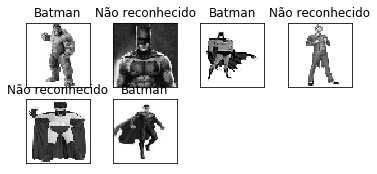

In [16]:
import matplotlib.pyplot as plt

test_data = process_test_data()
#exibição do resultado
fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # Batman: [1,0]
    # Superman: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    print(model_out)
    if (model_out[0] > 0.8 and model_out[1] < 0.8): str_label='Batman'
    elif (model_out[0] < 0.2 and model_out[1] > 0.9): str_label='Superman'
    else: str_label='Não reconhecido'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
